<a href="https://colab.research.google.com/github/uma-s-iyer/south-indian-breakfast-classifier/blob/main/indian_breakfast_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Indian Breakfast Classifier .
This is going to be a simple computer vision model to identify few categories of Indian breakfast,
Why?
Just coz the food101 dataset doesn't appeal to me as a south indian! Just want to have some fun trying to classify southindian common breakfast.
And just somr coding practice.

Let's get on hey!

#2. Setting up the data.
I have curated few images of some basic top food classes that you commonly find in South Indian breakfasts.
I have used the `pygoogle_image` package to get the data.


Data available at [Source](https://github.com/uma-s-iyer/south-indian-breakfast-classifier/raw/main/data/images.zip)

To download your own data, use the followin =g code with any keyword and limit.
```python
from pygoogle_image import image as pi
pi.download(keywords='FOOD_NAME', limit=100)
```

## 1. Download data from github

In [1]:
from pathlib import Path
import requests
import zipfile

data = Path("data/")
images_path = data / "images"

if images_path.is_dir():
  print("Directory exists")
else:
  print("[INFO] Image directory does not exist. Creating one...")
  images_path.mkdir(parents=True,
                    exist_ok=True)
  with open (images_path / "food.zip", "wb" ) as f:
    request = requests.get("https://github.com/uma-s-iyer/south-indian-breakfast-classifier/raw/main/data/images.zip")
    print("Downloading data for food classification...")
    f.write(request.content)
  with zipfile.ZipFile(images_path / "food.zip", "r" ) as zip_ref:
    print("Unzipping data contents")
    zip_ref.extractall(images_path)

[INFO] Image directory does not exist. Creating one...
Unzipping data contents


##2. Check data contents

In [2]:
image_file_path = images_path / "images"

In [3]:
import os

for dirpath, dirnames, filenames in os.walk(image_file_path):
  print(f"There are {len(dirnames)} directories and {len(filenames)} in {dirpath}")

There are 6 directories and 0 in data/images/images
There are 0 directories and 93 in data/images/images/idly
There are 0 directories and 99 in data/images/images/poori
There are 0 directories and 99 in data/images/images/dosa
There are 0 directories and 99 in data/images/images/pongal
There are 0 directories and 93 in data/images/images/kichdi
There are 0 directories and 99 in data/images/images/vada


##3. Get various imports

In [4]:
#3. Get various imports
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


##4 Set device agnostic code

In [5]:
#4 Set device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

##5 Split the data into train and test

In [6]:
#5 Split the data into train and test
import os
import shutil
import random
from pathlib import Path

# Path to the original data folder
original_data_path = 'data/images/images'

# Split size (e.g., 80% train, 20% test)
split_size = 0.8

# Path to the new data folder structure
data_new_path = Path('data_new')

# Create 'train' and 'test' folders within 'data_new'
train_path = data_new_path / "train"
test_path = data_new_path / "test"
train_path.mkdir(parents=True, exist_ok=True)
test_path.mkdir(parents=True, exist_ok=True)
print("path created")

# List all categories in the original data folder
categories = os.listdir(original_data_path)

# Iterate over each category
for category in categories:
  #print(category)
  category_path = os.path.join(original_data_path, category)
  if os.path.isdir(category_path):
    #print(f"in if: {category_path}")
    # Create category folders in train and test paths
    train_category_path = train_path / category
    test_category_path = test_path / category
    train_category_path.mkdir(parents=True, exist_ok=True)
    test_category_path.mkdir(parents=True, exist_ok=True)

    # List all files in the category folder
    files = os.listdir(category_path)
    random.shuffle(files)  # Shuffle files randomly

    # Split files into train and test sets
    split_index = int(len(files) * split_size)
    train_files = files[:split_index]
    test_files = files[split_index:]

    # Move train files
    for train_file in train_files:
        src = os.path.join(category_path, train_file)
        dst = os.path.join(train_category_path, train_file)
        shutil.copy(src, dst)

    # Move test files
    for test_file in test_files:
        src = os.path.join(category_path, test_file)
        dst = os.path.join(test_category_path, test_file)
        shutil.copy(src, dst)

print("Data splitting and organizing into train and test sets complete.")

path created
Data splitting and organizing into train and test sets complete.


##6 Check the data contents size of test and train folders.

In [7]:
train_files_len = sum([len(files) for r, d, files in os.walk(train_path)])
test_files_len = sum([len(files) for r, d, files in os.walk(test_path)])
train_files_len, test_files_len

(464, 118)

#3. Setting up the Pre-trained Model

##1. Create model and get weights, transforms

In [10]:
from torchvision import models
def create_model(out_features: int = 6):
  weights = models.EfficientNet_B2_Weights.DEFAULT
  #2. Get the transforms
  transforms = weights.transforms()

  model = models.efficientnet_b2(weights=weights)
  for param in model.parameters():
    param.requires_grad = False
  model.classifier = torch.nn.Sequential( nn.Dropout(p=0.3, inplace=True),
                                          nn.Linear(in_features=1408, out_features=out_features, bias= True))
  return model, weights, transforms

#4. Create Custom Datasets and Dataloaders

##1. Create train and test data sets

In [11]:
model, weights, transforms = create_model()

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 184MB/s]


In [12]:
#1. Create train and test data sets
from torchvision import datasets
#Use ImageFolder to convert to datasets
train_data = datasets.ImageFolder(train_path, transform = transforms)
test_data = datasets.ImageFolder(test_path, transform = transforms)
class_names = train_data.classes
print(len(train_data), len(test_data), len(class_names))
print(class_names)


464 118 6
['dosa', 'idly', 'kichdi', 'pongal', 'poori', 'vada']


##2. Create train and test data loaders

In [13]:
#2. Create train and test data loaders
from torch.utils.data import DataLoader

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)
print(f"There are {len(train_dataloader)} of batch_size: 32")
print(f"There are {len(test_dataloader)} of batch_size: 32")

There are 15 of batch_size: 32
There are 4 of batch_size: 32


In [14]:
from typing import List
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)
    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
      targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
      # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
      targ_image_adjust = targ_image.permute(1, 2, 0)

      # Plot adjusted samples
      plt.subplot(1, n, i+1)
      plt.imshow(targ_image_adjust)
      plt.axis("off")
      if classes:
          title = f"class: {classes[targ_label]}"
          if display_shape:
              title = title + f"\nshape: {targ_image_adjust.shape}"
      plt.title(title)

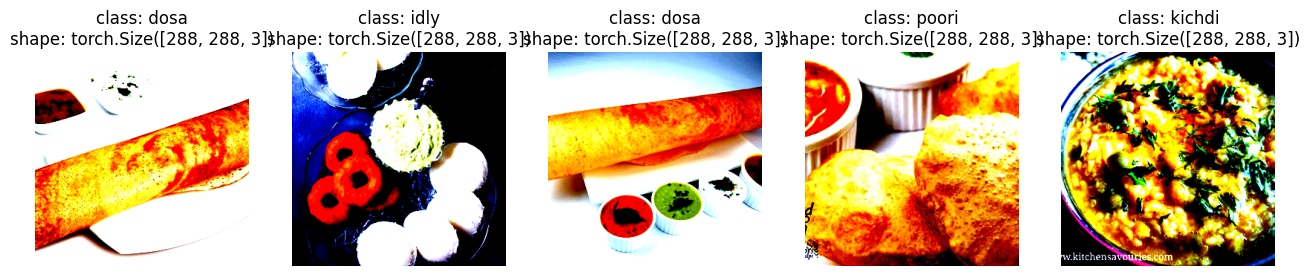

In [15]:
# Display random images from ImageFolder created Dataset

display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

In [17]:
#Sample forward pass:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
effnetb2, _, _ = create_model()
effnetb2.to(device)
effnetb2.eval()
with torch.inference_mode():
    pred = effnetb2(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 288, 288])

Output logits:
tensor([[ 0.0904, -0.0347, -0.0400,  0.0822,  0.1264,  0.0354]],
       device='cuda:0')

Output prediction probabilities:
tensor([[0.1744, 0.1539, 0.1530, 0.1729, 0.1808, 0.1650]], device='cuda:0')

Output prediction label:
tensor([4], device='cuda:0')

Actual label:
2


#5. Set up training Code

In [18]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [19]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [20]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [22]:
#2. Train the model
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()
model, weights, transforms = create_model()
model.to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
# Train model_0
results = train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=10)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6709 | train_acc: 0.3354 | test_loss: 1.3925 | test_acc: 0.7820
Epoch: 2 | train_loss: 1.2663 | train_acc: 0.7604 | test_loss: 1.0900 | test_acc: 0.8679
Epoch: 3 | train_loss: 1.0234 | train_acc: 0.8313 | test_loss: 0.8883 | test_acc: 0.9105
Epoch: 4 | train_loss: 0.8172 | train_acc: 0.8812 | test_loss: 0.7548 | test_acc: 0.8949
Epoch: 5 | train_loss: 0.7055 | train_acc: 0.8917 | test_loss: 0.6557 | test_acc: 0.9183
Epoch: 6 | train_loss: 0.6316 | train_acc: 0.8812 | test_loss: 0.5768 | test_acc: 0.9261
Epoch: 7 | train_loss: 0.5241 | train_acc: 0.9271 | test_loss: 0.5184 | test_acc: 0.9261
Epoch: 8 | train_loss: 0.4746 | train_acc: 0.9229 | test_loss: 0.4843 | test_acc: 0.9339
Epoch: 9 | train_loss: 0.4564 | train_acc: 0.9292 | test_loss: 0.4476 | test_acc: 0.9339
Epoch: 10 | train_loss: 0.4194 | train_acc: 0.9250 | test_loss: 0.4183 | test_acc: 0.9261
Total training time: 214.061 seconds


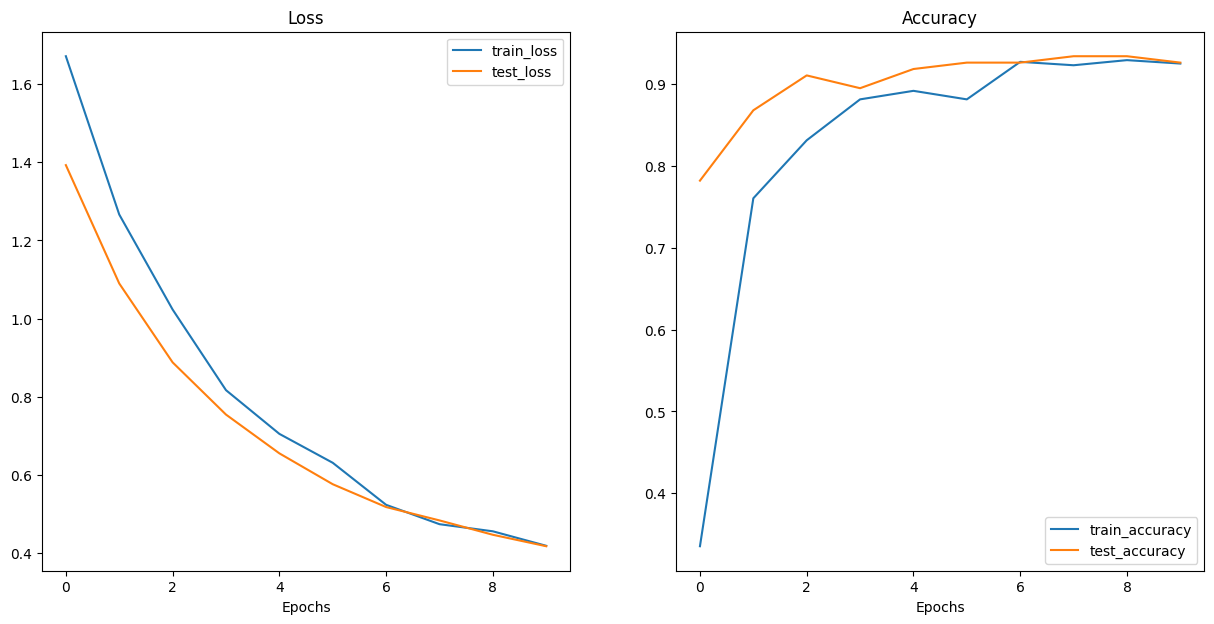

In [27]:
#3. Plot loss curves
from typing import List, Dict
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

plot_loss_curves(results)

In [28]:
#4. Set up model saver
import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  """Saves a PyTorch model to a target directory.
  """
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

save_model(model=model,
           target_dir="models",
           model_name="indi-bf-classifier.pth")

[INFO] Saving model to: models/indi-bf-classifier.pth


In [29]:
#5. Check model size and stats
from pathlib import Path

effnet_size = Path("models/indi-bf-classifier.pth").stat().st_size
print(f"Effnet Model Size: {effnet_size / (1024*1024):.2f} MB")

Effnet Model Size: 29.85 MB


#6 Set up Gradio

## 6.1. Create predict function for gradio

In [30]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.2/318.2 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 86.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 5.3 MB/s 

In [38]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm

from typing import List, Dict

def pred_and_store(paths: List[pathlib.Path],
                   model,
                   transform: torchvision.transforms,
                   class_names,
                   device: str) -> List[Dict]:
  pred_list = []
  #Loop thru
  for path in tqdm(paths):
    #create empty dict
    pred_dict={}
    #get sample.
    pred_dict["image_path"]=path
    class_name = path.parent.stem
    pred_dict["class_name"]=class_name
    #start timer
    start_time = timer()
    img = Image.open(path)
    #transform the image
    transformed_img = transform(img).unsqueeze(0).to(device)
    model = model.to(device)
    model.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_img)
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]
      pred_dict["pred_prob"]=round(pred_prob.unsqueeze(0).max().cpu().item(),4)
      pred_dict["pred_class"]=pred_class
      end_time = timer()
      pred_dict["time"] = round(end_time-start_time,4)
      pred_dict["correct"] = class_name == pred_class
    pred_list.append(pred_dict)
  return pred_list

In [32]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    model.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(model(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

In [34]:
test_path

PosixPath('data_new/test')

In [35]:
#2. Set up examples
# Create a list of example inputs to our Gradio demo
test_data_paths = list(Path(test_path).glob("*/*.jpeg"))
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data_new/test/kichdi/kichdi_75.jpeg'],
 ['data_new/test/idly/idly_34.jpeg'],
 ['data_new/test/vada/vada_95.jpeg']]

In [39]:
#make predictions.
effnetb2_test_res = pred_and_store(paths = test_data_paths,
                                   model=model,
                                   transform=transforms,
                                   device="cpu",
                                   class_names=class_names)

  0%|          | 0/115 [00:00<?, ?it/s]

In [40]:
import pandas as pd
effnetb2_df = pd.DataFrame(effnetb2_test_res)
effnetb2_df.correct.value_counts()

correct
True     107
False      8
Name: count, dtype: int64

In [42]:
#3. Gradio Demo
import gradio as gr
import gradio as gr

# Create title, description and article strings
title = "🍛Classify South-Indian Breakfast🍲"
description = "An EfficientNetB2 feature extractor computer vision model to classify south indian breakfast varieties such as idly, Dosa, Vada, Poori, Kichdi & Pongal"
article = "Created at based custom dataset."

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=2, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=True, # print errors locally?
            share=True) # generate a publically shareable URL?

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://ff881017f8c457e8d8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://595f45c0d09259dfe2.gradio.live
Killing tunnel 127.0.0.1:7861 <> https://8e8a03e2b843636fb2.gradio.live
Killing tunnel 127.0.0.1:7862 <> https://ff881017f8c457e8d8.gradio.live


#7. Deploy to Huggingface spaces

In [ ]:
#1. Hugging face repo structure set up

In [43]:
import shutil
from pathlib import Path

demo_path = Path("demos/indi/")

#remove if exists
if demo_path.exists():
  shutil.rmtree(demo_path)
demo_path.mkdir(parents=True,
                                exist_ok=True)

In [ ]:
#2. examples set up

In [46]:
import shutil
from pathlib import Path

# 1. Create an examples directory
examples_path = demo_path / "examples"
examples_path.mkdir(parents=True, exist_ok=True)

# 2. Copy the three random images to the examples directory
for example in random.sample(test_data_paths, k=3):
    destination = examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data_new/test/poori/poori_98.jpeg to demos/indi/examples/poori_98.jpeg
[INFO] Copying data_new/test/idly/idly_46.jpeg to demos/indi/examples/idly_46.jpeg
[INFO] Copying data_new/test/vada/vada_95.jpeg to demos/indi/examples/vada_95.jpeg


In [47]:
#verification
import os

examples_list = [["examples/" + example] for example in os.listdir(examples_path)]
examples_list

[['examples/idly_46.jpeg'],
 ['examples/.ipynb_checkpoints'],
 ['examples/vada_95.jpeg'],
 ['examples/poori_98.jpeg']]

In [ ]:
#3. model.py

In [48]:
import shutil

# Create a source path for our target model
model_path = "models/indi-bf-classifier.pth"

# Create a destination path for our target model
model_dest = demo_path / model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {model_path} to {model_dest}")

    # Move the model
    shutil.move(src=model_path,
                dst=model_dest)

    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {model_dest}: {model_dest.exists()}")

[INFO] Attempting to move models/indi-bf-classifier.pth to demos/indi/indi-bf-classifier.pth
[INFO] Model move complete.


In [49]:
%%writefile demos/indi/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=6,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demos/indi/model.py


In [ ]:
#4. app.py

In [51]:
%%writefile demos/indi/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ['dosa', 'idly', 'kichdi', 'pongal', 'poori', 'vada']
### 2. Model and transforms preparation ###

# Create model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=101, # could also use len(class_names)
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_exercise_caltech101_effnetb2.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "🍛Classify South-Indian Breakfast🍲"
description = "An EfficientNetB2 feature extractor computer vision model to classify south indian breakfast varieties such as idly, Dosa, Vada, Poori, Kichdi & Pongal"
article = "Created at based custom dataset."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create Gradio interface
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=2, label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ],
    examples=example_list,
    title=title,
    description=description,
    article=article,
)

# Launch the app!
demo.launch()

Writing demos/indi/app.py


In [ ]:
#5. Download files as zip

In [52]:
%%writefile demos/indi/requirements.txt
torch==2.3.0
torchvision==0.18.0
gradio

Writing demos/indi/requirements.txt


In [53]:
# Zip foodvision_big folder but exclude certain files
!cd demos/indi && zip -r ../indi.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Big app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/indi.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download()")

  adding: app.py (deflated 54%)
  adding: examples/ (stored 0%)
  adding: examples/idly_46.jpeg (deflated 3%)
  adding: examples/vada_95.jpeg (deflated 0%)
  adding: examples/poori_98.jpeg (deflated 3%)
  adding: indi-bf-classifier.pth (deflated 8%)
  adding: model.py (deflated 55%)
  adding: requirements.txt (deflated 5%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>